In [1]:
import numpy as np
from sklearn.model_selection import StratifiedKFold
import os
from sklearn import preprocessing
import warnings
from augmentations import augmentation_class
warnings.filterwarnings(action='ignore', category=DeprecationWarning)

In [101]:
DB_Path = '/Users/dfreire/Dropbox/Datasets/small_dataset/train/'

In [276]:
def Load_Data_Fold(DB_path, k=2):
    #Numeric labels
    lab = preprocessing.LabelEncoder()
    lab.fit(os.listdir(DB_path))
    labels = lab.transform(os.listdir(DB_path))
    inv = lab.inverse_transform(labels)
    class_dict = dict(zip(inv, labels))

    #Read each folder
    data=[]
    labels=[]
    for class_ in os.listdir(DB_path):
        dat = [os.path.join(DB_path, classes_, img) for img in os.listdir(os.path.join(DB_path, class_))]
        lab = np.ones(len(dat))*class_dict[class_]
        
        labels = np.concatenate((labels,lab))
        data = data + dat
    folds = list(StratifiedKFold(n_splits=k, shuffle=True, random_state=1).split(data, labels))
    
    return folds, data, labels

In [250]:
folds, data, labels = Load_Data_Fold(DB_path=DB_Path, k=1000)

In [251]:
len(folds)

1000

In [252]:
len(folds[0])

2

In [253]:
len(folds[0][0])

1998

In [254]:
len(folds[0][1])

2

In [255]:
2000/3

666.6666666666666

In [76]:
s = np.concatenate((a,b))

In [77]:
s

array([2., 2., 2., 2., 2., 3., 3., 3., 3., 3.])

In [ ]:
for j, (train_idx, val_idx) in enumerate(folds):
    
    print('\nFold ',j)
    X_train_cv = data[train_idx]
    y_train_cv = labels[train_idx]
    X_valid_cv = data[val_idx]
    y_valid_cv= labels[val_idx]
    
    name_weights = "final_model_fold" + str(j) + "_weights.h5"
    callbacks = get_callbacks(name_weights = name_weights, patience_lr=10)
    generator = gen.flow(X_train_cv, y_train_cv, batch_size = batch_size)
    model = get_model()
    model.fit_generator(
                generator,
                steps_per_epoch=len(X_train_cv)/batch_size,
                epochs=15,
                shuffle=True,
                verbose=1,
                validation_data = (X_valid_cv, y_valid_cv),
                callbacks = callbacks)
    
    print(model.evaluate(X_valid_cv, y_valid_cv))

In [30]:
# Enumerate labels

In [49]:
print(os.listdir(DB_Path))

['cats', 'dogs']


In [67]:
lab = preprocessing.LabelEncoder()
lab.fit(os.listdir(DB_Path))

LabelEncoder()

In [51]:
lab.classes_

array(['cats', 'dogs'], dtype='<U4')

In [52]:
labels = lab.transform(os.listdir(DB_Path))

In [53]:
print(labels)

[0 1]


In [62]:
inv = lab.inverse_transform(labels)
print(inv)

['cats' 'dogs']


In [65]:
class_dict = dict(zip(inv, labels))

In [277]:
# Our own generator

In [2]:
class DataGenerator(keras.utils.Sequence):
    """Generates data for Keras."""
    def __init__(self, img_files, labels, ave=None, std=None, batch_size=32, dim=(300, 300), n_channels=3,
                 n_classes=2, shuffle=True):
        """Initialization.
        
        Args:
            img_files: A list of path to image files.
            labels: A list of corresponding labels.
        """
        self.img_files = img_files
        self.labels = labels
        self.batch_size = batch_size
        self.dim = dim
        if ave is None:
            self.ave = np.zeros(n_channels)
        else:
            self.ave = ave
        if std is None:
            self.std = np.zeros(n_channels) + 1
        else:
            self.std = std
        
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        """Denotes the number of batches per epoch."""
        return int(np.floor(len(self.img_files) / self.batch_size))

    def __getitem__(self, index):
        """Generate one batch of data."""
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        img_files_temp = [self.img_files[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(img_files_temp)

        return X, y

    def on_epoch_end(self):
        """Updates indexes after each epoch."""
        self.indexes = np.arange(len(self.img_files))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, img_files_temp):
        """Generates data containing batch_size samples."""
        # X : (n_samples, *dim, n_channels)
        # X = [np.empty((self.batch_size, self.dim[0], self.dim[1], self.n_channels))]
        X = []
        X_clinical = []
        y = np.empty((self.batch_size), dtype=int)

        # Generate data
        for i, img_file in enumerate(img_files_temp):
            # Read image
            img = skimage.io.imread(img_file)
            
            # Resize
            img = skimage.transform.resize(img, output_shape=self.dim, mode='constant', preserve_range=True)
            
            # Normalization
            for ch in range(self.n_channels):
                img[:, :, ch] = (img[:, :, ch] - self.ave[ch])/self.std[ch]
            
            if self.shuffle:
                # Some image augmentation codes
                ###### You can put your preprocessing codes here. #####
                

            X.append(img)
            y[i] = self.labels[img_file]
        return X, keras.utils.to_categorical(y, num_classes=self.n_classes)

IndentationError: expected an indented block (<ipython-input-2-e593c8a17efe>, line 77)

https://github.com/tensorflow/models/issues/4668
conda install python=3.6
pip install tensorflow
pip install keras

In [16]:
#Create data generator https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly.html
import numpy as np
import keras
from PIL import Image as pil_image


if pil_image is not None:
    _PIL_INTERPOLATION_METHODS = {
        'nearest': pil_image.NEAREST,
        'bilinear': pil_image.BILINEAR,
        'bicubic': pil_image.BICUBIC,
    }
    # These methods were only introduced in version 3.4.0 (2016).
    if hasattr(pil_image, 'HAMMING'):
        _PIL_INTERPOLATION_METHODS['hamming'] = pil_image.HAMMING
    if hasattr(pil_image, 'BOX'):
        _PIL_INTERPOLATION_METHODS['box'] = pil_image.BOX
    # This method is new in version 1.1.3 (2013).
    if hasattr(pil_image, 'LANCZOS'):
        _PIL_INTERPOLATION_METHODS['lanczos'] = pil_image.LANCZOS
        
        

class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, img_files, labels, batch_size=32, target_size=(256,256), n_channels=3,
                 n_classes=10, shuffle=True, rescale=1., aug_mode='None'):
        'Initialization'
        self.target_size = target_size
        self.batch_size = batch_size
        self.labels = labels
        self.img_files = img_files
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.rescale=rescale
        self.augmentation= augmentation_class('StrongAug')
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.img_files) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_imgs_temp = [self.img_files[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(list_imgs_temp)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.img_files))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_imgs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = []
        y = np.empty((self.batch_size), dtype=int)

        # Generate data
        for i, img_file in enumerate(list_imgs_temp):
            # Store sample
            img = np.array(self.load_img(img_file, target_size=self.target_size))#skimage.io.imread(img_file)
            
            if self.rescale:
                img *= self.rescale
            
            augmented_img=aug.augment_img(img)
            while(np.array_equal(augmented_img,np.zeros(augmented_img.shape)) == True):  #Avoid black images
                augmented_img=aug.augment_img(img)
            
            X.append(augmented_img)

            # Store class
            y[i] = self.labels[i]

        return X, keras.utils.to_categorical(y, num_classes=self.n_classes)
    
    
      def load_img(self, path, grayscale=False, color_mode='rgb', target_size=None,
             interpolation='nearest'):
        """Loads an image into PIL format.
        # Arguments
            path: Path to image file.
            color_mode: One of "grayscale", "rbg", "rgba". Default: "rgb".
                The desired image format.
            target_size: Either `None` (default to original size)
                or tuple of ints `(img_height, img_width)`.
            interpolation: Interpolation method used to resample the image if the
                target size is different from that of the loaded image.
                Supported methods are "nearest", "bilinear", and "bicubic".
                If PIL version 1.1.3 or newer is installed, "lanczos" is also
                supported. If PIL version 3.4.0 or newer is installed, "box" and
                "hamming" are also supported. By default, "nearest" is used.
        # Returns
            A PIL Image instance.
        # Raises
            ImportError: if PIL is not available.
            ValueError: if interpolation method is not supported.
        """
        if grayscale is True:
            warnings.warn('grayscale is deprecated. Please use '
                          'color_mode = "grayscale"')
            color_mode = 'grayscale'
        if pil_image is None:
            raise ImportError('Could not import PIL.Image. '
                              'The use of `array_to_img` requires PIL.')
        img = pil_image.open(path)
        if color_mode == 'grayscale':
            if img.mode != 'L':
                img = img.convert('L')
        elif color_mode == 'rgba':
            if img.mode != 'RGBA':
                img = img.convert('RGBA')
        elif color_mode == 'rgb':
            if img.mode != 'RGB':
                img = img.convert('RGB')
        else:
            raise ValueError('color_mode must be "grayscale", "rbg", or "rgba"')
        if target_size is not None:
            width_height_tuple = (target_size[1], target_size[0])
            if img.size != width_height_tuple:
                if interpolation not in _PIL_INTERPOLATION_METHODS:
                    raise ValueError(
                        'Invalid interpolation method {} specified. Supported '
                        'methods are {}'.format(
                            interpolation,
                            ", ".join(_PIL_INTERPOLATION_METHODS.keys())))
                resample = _PIL_INTERPOLATION_METHODS[interpolation]
                img = img.resize(width_height_tuple, resample)
        return img  








In [4]:
DB_ruta = '/Users/dfreire/Dropbox/Datasets/small_dataset/train/cats'

In [5]:
lista = os.listdir(DB_ruta)

In [7]:
lista[:5]

['cat.0.jpg', 'cat.1.jpg', 'cat.10.jpg', 'cat.100.jpg', 'cat.101.jpg']

In [8]:
datos = [os.path.join(DB_ruta, u) for u in lista]

In [10]:
datos = datos[:10]

In [11]:
datos

['/Users/dfreire/Dropbox/Datasets/small_dataset/train/cats/cat.0.jpg',
 '/Users/dfreire/Dropbox/Datasets/small_dataset/train/cats/cat.1.jpg',
 '/Users/dfreire/Dropbox/Datasets/small_dataset/train/cats/cat.10.jpg',
 '/Users/dfreire/Dropbox/Datasets/small_dataset/train/cats/cat.100.jpg',
 '/Users/dfreire/Dropbox/Datasets/small_dataset/train/cats/cat.101.jpg',
 '/Users/dfreire/Dropbox/Datasets/small_dataset/train/cats/cat.102.jpg',
 '/Users/dfreire/Dropbox/Datasets/small_dataset/train/cats/cat.103.jpg',
 '/Users/dfreire/Dropbox/Datasets/small_dataset/train/cats/cat.104.jpg',
 '/Users/dfreire/Dropbox/Datasets/small_dataset/train/cats/cat.105.jpg',
 '/Users/dfreire/Dropbox/Datasets/small_dataset/train/cats/cat.106.jpg']

In [14]:
y = np.zeros(len(datos))

In [15]:
y

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [ ]:
# Parameters
params = {'batch_size': 64,
          'n_classes': 1,
          'n_channels': 3,
          'shuffle': True}

# Datasets
partition = # IDs
labels = # Labels

# Generators
training_generator = DataGenerator(partition['train'], labels, **params)
validation_generator = DataGenerator(partition['validation'], labels, **params)

# Design model
model = Sequential()
[...] # Architecture
model.compile()

# Train model on dataset
model.fit_generator(generator=training_generator,
                    validation_data=validation_generator,
                    use_multiprocessing=True,
                    workers=6)

In [20]:
image.shape

(349, 270, 3)

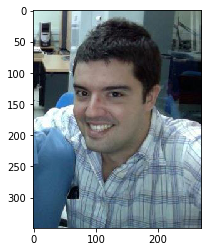

In [19]:
plt.imshow(image)

In [34]:
img = skimage.transform.resize(image, output_shape=(150,150,3), mode='constant', anti_aliasing=True)

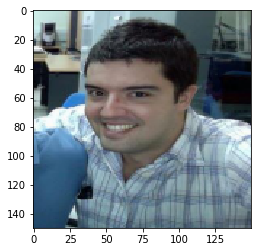

In [35]:
plt.imshow(img)

In [44]:
#https://github.com/keras-team/keras-preprocessing/blob/master/keras_preprocessing/image.py
from PIL import Image as pil_image

if pil_image is not None:
    _PIL_INTERPOLATION_METHODS = {
        'nearest': pil_image.NEAREST,
        'bilinear': pil_image.BILINEAR,
        'bicubic': pil_image.BICUBIC,
    }
    # These methods were only introduced in version 3.4.0 (2016).
    if hasattr(pil_image, 'HAMMING'):
        _PIL_INTERPOLATION_METHODS['hamming'] = pil_image.HAMMING
    if hasattr(pil_image, 'BOX'):
        _PIL_INTERPOLATION_METHODS['box'] = pil_image.BOX
    # This method is new in version 1.1.3 (2013).
    if hasattr(pil_image, 'LANCZOS'):
        _PIL_INTERPOLATION_METHODS['lanczos'] = pil_image.LANCZOS



def load_img(path, grayscale=False, color_mode='rgb', target_size=None,
             interpolation='nearest'):
    """Loads an image into PIL format.
    # Arguments
        path: Path to image file.
        color_mode: One of "grayscale", "rbg", "rgba". Default: "rgb".
            The desired image format.
        target_size: Either `None` (default to original size)
            or tuple of ints `(img_height, img_width)`.
        interpolation: Interpolation method used to resample the image if the
            target size is different from that of the loaded image.
            Supported methods are "nearest", "bilinear", and "bicubic".
            If PIL version 1.1.3 or newer is installed, "lanczos" is also
            supported. If PIL version 3.4.0 or newer is installed, "box" and
            "hamming" are also supported. By default, "nearest" is used.
    # Returns
        A PIL Image instance.
    # Raises
        ImportError: if PIL is not available.
        ValueError: if interpolation method is not supported.
    """
    if grayscale is True:
        warnings.warn('grayscale is deprecated. Please use '
                      'color_mode = "grayscale"')
        color_mode = 'grayscale'
    if pil_image is None:
        raise ImportError('Could not import PIL.Image. '
                          'The use of `array_to_img` requires PIL.')
    img = pil_image.open(path)
    if color_mode == 'grayscale':
        if img.mode != 'L':
            img = img.convert('L')
    elif color_mode == 'rgba':
        if img.mode != 'RGBA':
            img = img.convert('RGBA')
    elif color_mode == 'rgb':
        if img.mode != 'RGB':
            img = img.convert('RGB')
    else:
        raise ValueError('color_mode must be "grayscale", "rbg", or "rgba"')
    if target_size is not None:
        width_height_tuple = (target_size[1], target_size[0])
        if img.size != width_height_tuple:
            if interpolation not in _PIL_INTERPOLATION_METHODS:
                raise ValueError(
                    'Invalid interpolation method {} specified. Supported '
                    'methods are {}'.format(
                        interpolation,
                        ", ".join(_PIL_INTERPOLATION_METHODS.keys())))
            resample = _PIL_INTERPOLATION_METHODS[interpolation]
            img = img.resize(width_height_tuple, resample)
    return img

In [51]:
image = load_img(path='/Users/dfreire/Dropbox/Web/yo1.jpg', target_size=(300,300))

(300, 300, 3)


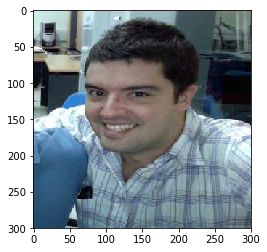

In [52]:
plt.imshow(image)
print(np.array(image).shape)

In [62]:
x = np.empty((4, 5, 5, 3))

In [63]:
x.shape

(4, 5, 5, 3)

In [65]:
a = np.ones((3,5,5))*3

In [66]:
a

array([[[3., 3., 3., 3., 3.],
        [3., 3., 3., 3., 3.],
        [3., 3., 3., 3., 3.],
        [3., 3., 3., 3., 3.],
        [3., 3., 3., 3., 3.]],

       [[3., 3., 3., 3., 3.],
        [3., 3., 3., 3., 3.],
        [3., 3., 3., 3., 3.],
        [3., 3., 3., 3., 3.],
        [3., 3., 3., 3., 3.]],

       [[3., 3., 3., 3., 3.],
        [3., 3., 3., 3., 3.],
        [3., 3., 3., 3., 3.],
        [3., 3., 3., 3., 3.],
        [3., 3., 3., 3., 3.]]])

In [67]:
x

array([[[[0.00000000e+000, 0.00000000e+000, 0.00000000e+000],
         [6.94466723e-310, 1.97626258e-323, 0.00000000e+000],
         [            nan, 2.22329541e-322, 2.12199579e-314],
         [0.00000000e+000, 3.95252517e-323, 5.98766765e-313],
         [6.94466723e-310, 9.88131292e-324, 0.00000000e+000]],

        [[            nan, 2.22329541e-322, 2.12199579e-314],
         [3.55727265e-322, 3.95252517e-323, 5.98766765e-313],
         [6.94466723e-310, 9.88131292e-324, 0.00000000e+000],
         [            nan, 4.15015143e-322, 2.12199579e-314],
         [7.11454530e-322, 3.95252517e-323, 5.98766765e-313]],

        [[6.94466723e-310, 9.88131292e-324, 0.00000000e+000],
         [            nan, 2.86558075e-322, 0.00000000e+000],
         [1.06718180e-321, 3.95252517e-323, 5.98766765e-313],
         [6.94466723e-310, 9.88131292e-324, 0.00000000e+000],
         [            nan, 2.86558075e-322, 0.00000000e+000]],

        [[1.42290906e-321, 3.95252517e-323, 5.98766765e-313],
  

In [68]:
x[0,] = a

ValueError: could not broadcast input array from shape (3,5,5) into shape (5,5,3)

In [18]:
from urllib.request import urlopen
import numpy as np
import cv2
from matplotlib import pyplot as plt

In [9]:
from albumentations import (
    HorizontalFlip, IAAPerspective, ShiftScaleRotate, CLAHE, RandomRotate90,
    Transpose, ShiftScaleRotate, Blur, OpticalDistortion, GridDistortion, HueSaturationValue,
    IAAAdditiveGaussianNoise, GaussNoise, MotionBlur, MedianBlur, IAAPiecewiseAffine,
    IAASharpen, IAAEmboss, RandomContrast, RandomBrightness, Flip, OneOf, Compose
)

In [3]:
def download_image(url):
    data = urlopen(url).read()
    data = np.frombuffer(data, np.uint8)
    image = cv2.imdecode(data, cv2.IMREAD_COLOR)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image

In [4]:
image = download_image('https://d177hi9zlsijyy.cloudfront.net/wp-content/uploads/sites/2/2018/05/11202041/180511105900-atlas-boston-dynamics-robot-running-super-tease.jpg')

In [1]:
from matplotlib import pyplot as plt

In [17]:
import skimage.io
image = skimage.io.imread('/Users/dfreire/Dropbox/Web/yo1.jpg')

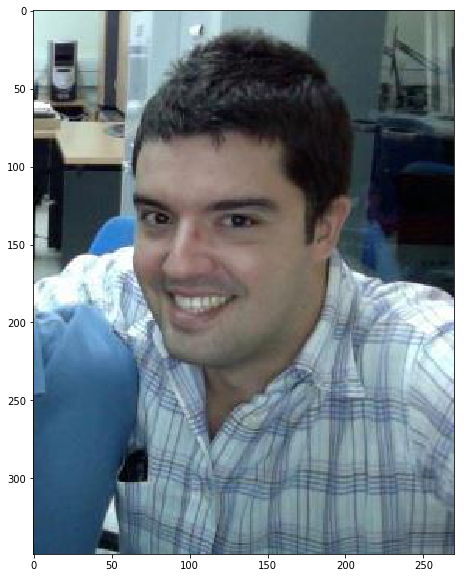

In [3]:
plt.figure(figsize=(10, 10))
plt.imshow(image)
plt.show()

In [33]:
def augment_and_show(aug, image):
    image = aug(image=image)['image']
    plt.figure(figsize=(10, 10))
    plt.imshow(image)

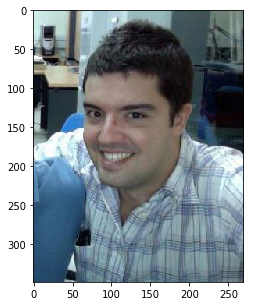

In [184]:
aug = HorizontalFlip(p=1)
#augment_and_show(aug, image)
image = aug(image=image)['image']
plt.figure(figsize=(5, 5))
plt.imshow(image)

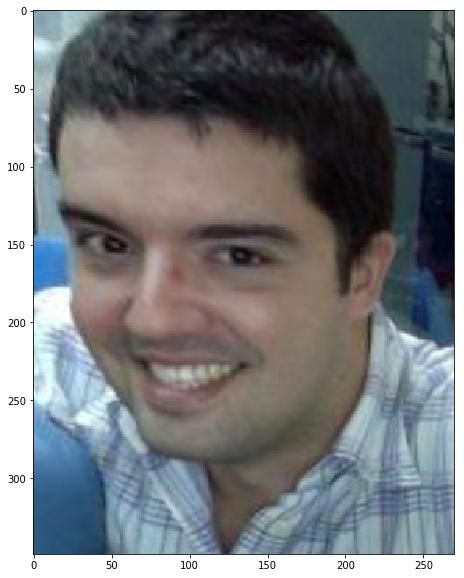

In [188]:
aug = IAAPerspective(scale=0.2, p=1)
augment_and_show(aug, image)

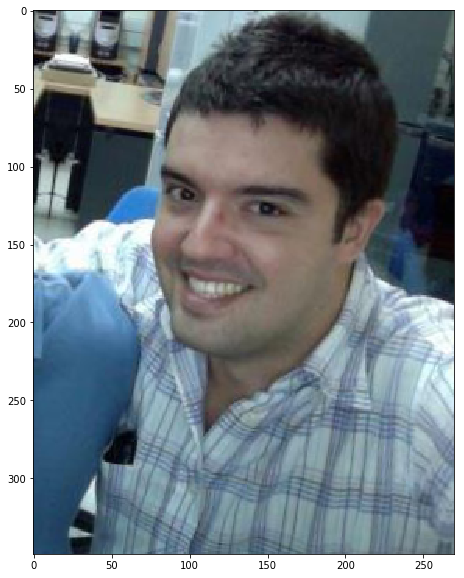

In [190]:
aug = ShiftScaleRotate(p=1)
augment_and_show(aug, image)

In [28]:
def augment_flips_color(p=.5):
    return Compose([
        CLAHE(),
        RandomRotate90(),
        Transpose(),
        ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.50, rotate_limit=45, p=.75),
        Blur(blur_limit=3),
        OpticalDistortion(),
        GridDistortion(),
        HueSaturationValue()
    ], p=p)

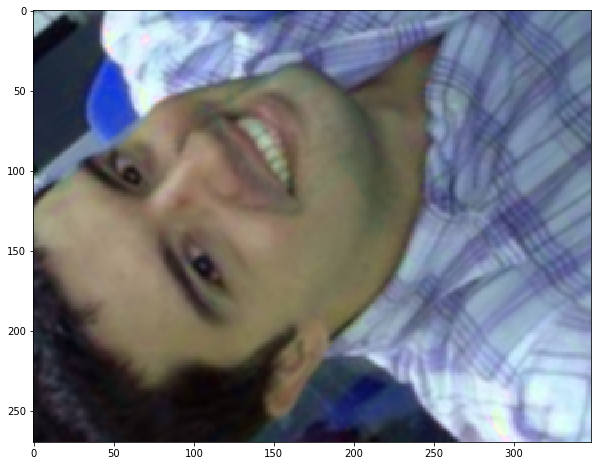

In [67]:
aug = augment_flips_color(p=1)
augment_and_show(aug, image)

In [11]:
def strong_aug(p=.5):
    return Compose([
        RandomRotate90(),
        Flip(),
        Transpose(),
        OneOf([
            IAAAdditiveGaussianNoise(),
            GaussNoise(),
        ], p=0.2),
        OneOf([
            MotionBlur(p=.2),
            MedianBlur(blur_limit=3, p=.1),
            Blur(blur_limit=3, p=.1),
        ], p=0.2),
        ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=45, p=.2),
        OneOf([
            OpticalDistortion(p=0.3),
            GridDistortion(p=.1),
            IAAPiecewiseAffine(p=0.3),
        ], p=0.2),
        OneOf([
            CLAHE(clip_limit=2),
            IAASharpen(),
            IAAEmboss(),
            RandomContrast(),
            RandomBrightness(),
        ], p=0.3),
        HueSaturationValue(p=0.3),
    ], p=p)

In [12]:
counter_equal=0
for i in range(100):
    aug = strong_aug(p=1)
    #augment_and_show(aug, image)
    out = aug(image=image)['image']
    if(np.array_equal(out,image) == True):
        counter_equal=counter_equal+1
print(counter_equal)


//anaconda/envs/SCI_env/lib/python3.7/site-packages/albumentations/augmentations/functional.py:271: RuntimeWarning: invalid value encountered in true_divide
  return cv2.filter2D(img, -1, kernel / np.sum(kernel))


3


In [3]:
from augmentations import augmentation_class

In [5]:
aug = augmentation_class('StrongAugmentation')

False


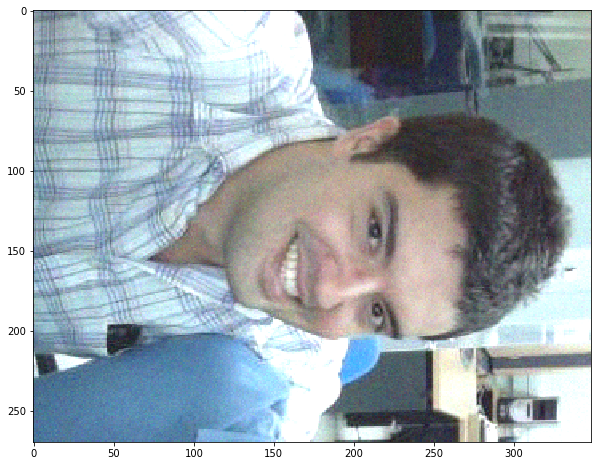

In [11]:
import numpy as np
plt.figure(figsize=(10, 10))
output=aug.augment_data(image,p=.9)#aug.augment_img(image)
print(np.array_equal(output,image))
plt.imshow(output)

In [216]:
output.shape
zero_img = np.zeros(output.shape)
zero_img.shape

(349, 270, 3)

In [27]:
import numpy as np
np.seterr(divide='ignore', invalid='ignore')
counter_equal=0
img = []
aug = augmentation_class('StrongAugmentation')
for i in range(100):
    #augment_and_show(aug, image)
    out=aug.augment_img(image,p=1)
    while(np.array_equal(out,np.zeros(out.shape)) == True):  #Avoid black images
        out=aug.augment_img(image,p=1)
    
    if(np.array_equal(out,image) == True):
        counter_equal=counter_equal+1
    if(np.array_equal(out,np.zeros(out.shape)) == True):
        print('THE GREAT IS ON THE PEPINO')   
    img.append(out)
print(counter_equal)

6


In [9]:
26/1000

0.026

In [64]:
i=0

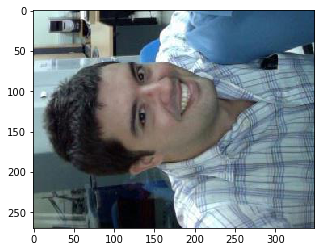

In [82]:
plt.imshow(img[i])
i=i+1